## 1: Library Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tqdm import tqdm
import os
import cv2 # Needed custom Docker file, but all issues now resolved!
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing, Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.losses import BinaryCrossentropy

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 15
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
hasTumor = False

In [4]:
if hasTumor == True:
    MAIN_DIR = "../cnn-gan-data/Br35H/tumorous"
else:
    MAIN_DIR = "../cnn-gan-data/Br35H/nontumorous"

## 2: Image Loading and Preprocessing

In [5]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [6]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((1500, 128, 128), (1500,))

In [7]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [8]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

In [9]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

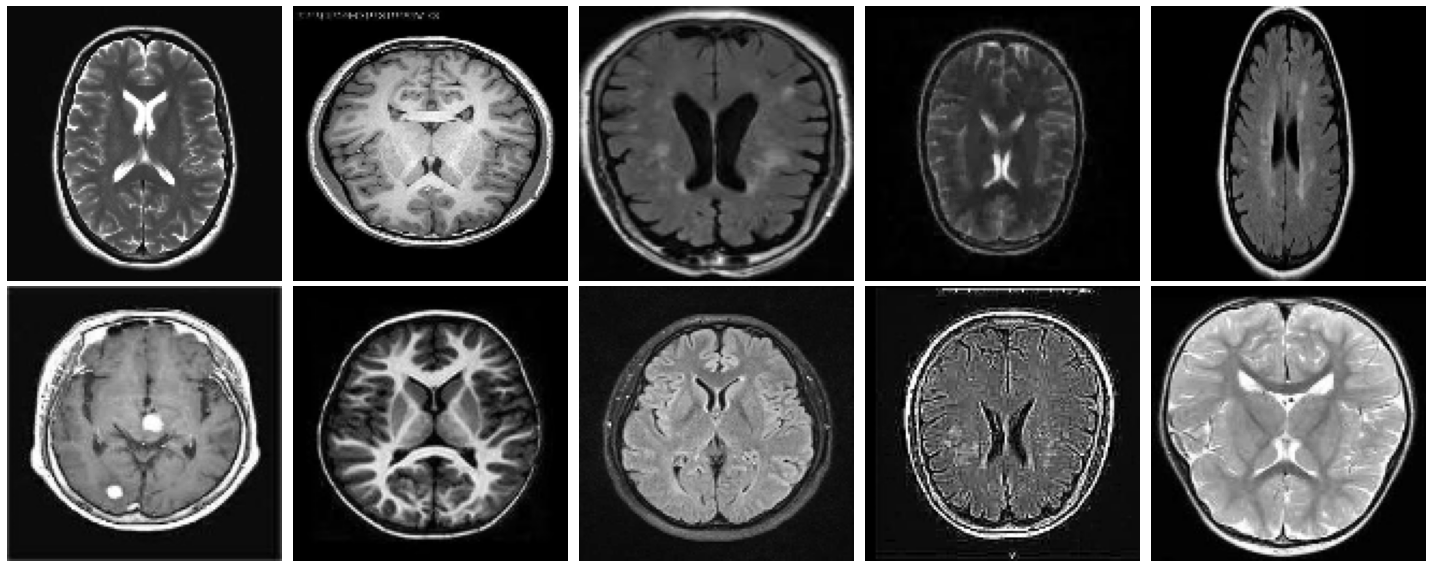

In [10]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

## 3: dc-GAN Architecture

In [11]:
def build_generator():
    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [12]:
def build_discriminator():
    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

## 4: Combining Generator and Discriminator

In [13]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)   

In [14]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            if hasTumor == True:
                plt.savefig("../cnn-gan-data/train-images/yes-tumor/unrolled-images/"+img_name)
            else:
                plt.savefig("../cnn-gan-data/train-images/no-tumor/unrolled-images/"+img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
def image_saves(noise, num, figsize=(22,8)):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        img_name = "gen" + str(i)
        plt.axis('off')
        if hasTumor == True:
            if EPOCHS == 5:
                plt.savefig("../cnn-gan-data/train-images/yes-tumor/unrolled-images/Epochs5/"+img_name, bbox_inches="tight", pad_inches=0)
            if EPOCHS == 15:
                plt.savefig("../cnn-gan-data/train-images/yes-tumor/unrolled-images/Epochs15/"+img_name, bbox_inches="tight", pad_inches=0)
            if EPOCHS == 25:
                plt.savefig("../cnn-gan-data/train-images/yes-tumor/unrolled-images/Epochs25/"+img_name, bbox_inches="tight", pad_inches=0)
        else:
            if EPOCHS == 5:
                plt.savefig("../cnn-gan-data/train-images/no-tumor/unrolled-images/Epochs5/"+img_name, bbox_inches="tight", pad_inches=0)
            if EPOCHS == 15:
                plt.savefig("../cnn-gan-data/train-images/no-tumor/unrolled-images/Epochs15/"+img_name, bbox_inches="tight", pad_inches=0)
            if EPOCHS == 25:
                plt.savefig("../cnn-gan-data/train-images/no-tumor/unrolled-images/Epochs25/"+img_name, bbox_inches="tight", pad_inches=0)

In [16]:
#----------------------------------------------- NEW FUNCTION --------------------------------------------------------
#def generator_loss(generated_images, images, pseudodiscriminator):
    # five unrollings.  Change to taste.
    #for i in range(5):
        #train the discriminator forward a few steps
        #pseudodiscriminator(images)
        #fake_output = pseudodiscriminator(generated_images)
        #if i == 0:
            #unrolled_loss = fake_output
        #else:
            #unrolled_loss = tf.concat([unrolled_loss, fake_output], axis=0)
    #unrolled_loss = tf.squeeze(unrolled_loss)
    #return cross_entropy(tf.ones_like(unrolled_loss), unrolled_loss)

In [17]:
#----------------------------------------------- NEW FUNCTION --------------------------------------------------------
def pseudo_loss(X, disc_y, pseudodiscriminator):
    # five unrollings.  Change to taste.
    for i in range(5):
        #train the discriminator forward a few steps
        pseudo_loss = pseudodiscriminator.train_on_batch(X, disc_y)
    return pseudo_loss

In [ ]:
#---------------------------------------------Replaces next cell --------------------------------------------------------
np.random.seed(SEED)
pseudodiscriminator = build_discriminator()
pseudodiscriminator.trainable = False 
for epoch in range(EPOCHS):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        #d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        d_loss = pseudo_loss(X, disc_y, pseudodiscriminator) # changed
        g_loss = gan.train_on_batch(noise, y_gen) # Moved down one line
        d_loss = discriminator.train_on_batch(X, disc_y) # moved from where it was before

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)     

  9%|▉         | 337/3750 [00:52<08:19,  6.83it/s]

In [ ]:
# np.random.seed(SEED)
# for epoch in range(EPOCHS):
#     for batch in tqdm(range(STEPS_PER_EPOCH)):

#         noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
#         fake_X = generator.predict(noise)
        
#         idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
#         real_X = X_train[idx]

#         X = np.concatenate((real_X, fake_X))

#         disc_y = np.zeros(2*BATCH_SIZE)
#         disc_y[:BATCH_SIZE] = 1

#         d_loss = discriminator.train_on_batch(X, disc_y)
        
#         y_gen = np.ones(BATCH_SIZE)
#         g_loss = gan.train_on_batch(noise, y_gen)

#     print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
#     noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
#     sample_images(noise, (2,5))

## 5: Generated Images Display

In [ ]:
noise = np.random.normal(0, 1, size=(500, NOISE_DIM))
sample_images(noise, (50,10), (24,20), save=False)
image_saves(noise, 500)

## 6. Generated Sample Evaluations

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (18, 10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label = 'Generated Images', hist = True, color = "#0c06c7", ax = axs)

axs.legend(loc = 'upper right', prop = {'size': 12})

plt.show